<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Neural Collaborative Filtering (NCF)

This notebook serves as an introduction to Neural Collaborative Filtering (NCF), which is an innovative algorithm based on deep neural networks to tackle the key problem in recommendation — collaborative filtering — on the basis of implicit feedback.

## 0 Global Settings and Imports

In [2]:
import sys
sys.path.append("../../")
import time
import os
import shutil
import papermill as pm
import pandas as pd
import numpy as np
import tensorflow as tf
from reco_utils.recommender.ncf.ncf_singlenode import NCF
from reco_utils.recommender.ncf.dataset import Dataset as NCFDataset
from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_chrono_split
from reco_utils.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

from datetime import datetime

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
Pandas version: 0.24.1
Tensorflow version: 1.12.0


In [3]:
# top k items to recommend
TOP_K = 10

# Select Movielens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# # Model parameters
# EPOCHS = 200
# BATCH_SIZE = 256

In [64]:
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)

df["datetime"] = df["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x))
df["dayofweek"] = df["datetime"].apply(lambda x: x.weekday())
df["hourofday"] = df["datetime"].apply(lambda x: x.hour)
df["monthofyear"] = df["datetime"].apply(lambda x: x.month)
df.head()

,userID,itemID,rating,timestamp,datetime,dayofweek,hourofday,monthofyear
0,196,242,3.0,881250949,1997-12-04 15:55:49,3,15,12
1,186,302,3.0,891717742,1998-04-04 19:22:22,5,19,4
2,22,377,1.0,878887116,1997-11-07 07:18:36,4,7,11
3,244,51,2.0,880606923,1997-11-27 05:02:03,3,5,11
4,166,346,1.0,886397596,1998-02-02 05:33:16,0,5,2


In [67]:
train, test = python_chrono_split(df, 0.75)

In [6]:
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Reshape
from keras.layers import Dot
from keras.models import Model
from keras.layers import Concatenate
from keras.layers import Dense
from keras.layers import Dropout


## Experiment 1

In [8]:
###############
# NN structure for pure MF
###############

user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 100
user_count = df.userID.unique().shape[0]
item_count = df.itemID.unique().shape[0]


###############
# NN structure
###############

user_embedding = Embedding(output_dim=embedding_size, input_dim=user_count,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=item_count,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

y = Dot(1, normalize=False)([user_vecs, item_vecs])

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam"
             )

In [ ]:
###############
# Run the network
###############

import time
from keras.callbacks import ModelCheckpoint

mainpath = '/home/admin711/notebooks/tian/result/deep_beer_try_out'
save_path = mainpath + "/model"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'matrix_facto_5_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename, monitor='val_loss', save_best_only=True)

history = model.fit([train["userID"], train["itemID"]]
                    , train["rating"]
                    , batch_size=64, epochs=30
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

import pickle
with open(mainpath + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Experiment 2

In [7]:
###############
# NN structure with user and item embedding and a few more layers
###############

user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 100
user_count = df.userID.unique().shape[0]
item_count = df.itemID.unique().shape[0]


###############
# NN structure
###############

user_embedding = Embedding(output_dim=embedding_size, input_dim=user_count,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=item_count,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs])

x = Dense(32, activation='relu')(input_vecs)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

y = Dense(1)(x)


model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mse')  

In [9]:
###############
# Run the network
###############

import time
from keras.callbacks import ModelCheckpoint

mainpath = '/home/admin711/notebooks/tian/result/deep_beer_try_out'
save_path = mainpath + "/model"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'matrix_facto_5_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename, monitor='val_loss', save_best_only=True)

history = model.fit([train["userID"], train["itemID"]]
                    , train["rating"]
                    , batch_size=64, epochs=30
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

import pickle
with open(mainpath + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 67492 samples, validate on 7500 samples
Epoch 1/30
67492/67492 [==============================] - 33s 490us/step - loss: 1.7728 - val_loss: 1.2139
Epoch 2/30
67492/67492 [==============================] - 4s 56us/step - loss: 0.9392 - val_loss: 1.0547
Epoch 3/30
67492/67492 [==============================] - 4s 58us/step - loss: 0.8768 - val_loss: 1.0304
Epoch 4/30
67492/67492 [==============================] - 4s 57us/step - loss: 0.8508 - val_loss: 1.0302
Epoch 5/30
67492/67492 [==============================] - 4s 57us/step - loss: 0.8313 - val_loss: 0.9855
Epoch 6/30
67492/67492 [==============================] - 4s 57us/step - loss: 0.8130 - val_loss: 1.0695
Epoch 7/30
67492/67492 [==============================] - 4s 57us/step - loss: 0.7959 - val_loss: 1.0828
Epoch 8/30
67492/67492 [==============================] - 4s 56us/step - loss: 0.7797 - val_loss: 1.0491
Epoch 9/30
67492/67492 [==============================] - 4s 57us/step - loss: 0.7592 - val_loss: 1.0630
Epoc

## Experiment 3

In [85]:
###############
# NN structure with contactual information
# Day of week (as embeding)
###############

user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
dayofweek_input = Input(shape=[1], name='dayofweek')

embedding_size_user = 40
embedding_size_item = 40
embedding_size_dayofweek = 7

user_count = df.userID.unique().shape[0]
item_count = df.itemID.unique().shape[0]
dayofweek_count = df.dayofweek.unique().shape[0]

###############
# NN structure 
###############

user_embedding = Embedding(output_dim=embedding_size_user, input_dim=user_count,
                           input_length=1, name='user_embedding')(user_id_input)

item_embedding = Embedding(output_dim=embedding_size_item, input_dim=item_count,
                           input_length=1, name='item_embedding')(item_id_input)

dayofweek_embedding = Embedding(output_dim=embedding_size_dayofweek, input_dim=dayofweek_count,
                           input_length=1, name='dayofweek_embedding')(dayofweek_input)

user_vecs = Reshape([embedding_size_user])(user_embedding)
item_vecs = Reshape([embedding_size_item])(item_embedding)
dayofweek_vecs = Reshape([embedding_size_dayofweek])(dayofweek_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs, dayofweek_vecs])

x = Dropout(0.3)(input_vecs)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

y = Dense(1)(x)


model = Model(inputs=[user_id_input, item_id_input, dayofweek_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam"
             )

In [86]:
import time
from keras.callbacks import ModelCheckpoint

mainpath = '/home/admin711/notebooks/tian/result/deep_beer_try_out'
save_path = mainpath + "/model"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'matrix_facto_5_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename, monitor='val_loss', save_best_only=True)

history = model.fit([train["userID"], train["itemID"], train["dayofweek"]]
                    , train["rating"]
                    , batch_size=128, epochs=30
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

import pickle
with open(mainpath + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 67492 samples, validate on 7500 samples
Epoch 1/30
67492/67492 [==============================] - 3s 38us/step - loss: 2.3118 - val_loss: 1.2318
Epoch 2/30
67492/67492 [==============================] - 2s 30us/step - loss: 0.9964 - val_loss: 1.0549
Epoch 3/30
67492/67492 [==============================] - 2s 30us/step - loss: 0.9190 - val_loss: 1.0094
Epoch 4/30
67492/67492 [==============================] - 2s 30us/step - loss: 0.8868 - val_loss: 1.0021
Epoch 5/30
67492/67492 [==============================] - 2s 31us/step - loss: 0.8668 - val_loss: 0.9933
Epoch 6/30
67492/67492 [==============================] - 2s 30us/step - loss: 0.8560 - val_loss: 0.9908
Epoch 7/30
67492/67492 [==============================] - 2s 30us/step - loss: 0.8418 - val_loss: 0.9866
Epoch 8/30
67492/67492 [==============================] - 2s 30us/step - loss: 0.8356 - val_loss: 0.9752
Epoch 9/30
67492/67492 [==============================] - 2s 30us/step - loss: 0.8304 - val_loss: 0.9799
Epoch 

## Experiment 4

In [87]:
###############
# NN structure with contactual information
# Day of week (as input to dense layer)
# Time of day (as input to dense layer)
###############

user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
dayofweek_input = Input(shape=[1], name='dayofweek')
hourofday_input = Input(shape=[1], name='hourofday')
monthofyear_input = Input(shape=[1], name='monthofyear')

embedding_size_user = 40
embedding_size_item = 40
embedding_size_dayofweek = 7

user_count = df.userID.unique().shape[0]
item_count = df.itemID.unique().shape[0]
dayofweek_count = df.dayofweek.unique().shape[0]
print (user_count, item_count, dayofweek_count)



##############
# NN structure
##############
user_embedding = Embedding(output_dim=embedding_size_user, input_dim=user_count,
                           input_length=1, name='user_embedding')(user_id_input)

item_embedding = Embedding(output_dim=embedding_size_item, input_dim=item_count,
                           input_length=1, name='item_embedding')(item_id_input)

# dayofweek_embedding = Embedding(output_dim=embedding_size_dayofweek, input_dim=dayofweek_count,
#                            input_length=1, name='dayofweek_embedding')(dayofweek_input)

user_vecs = Reshape([embedding_size_user])(user_embedding)
item_vecs = Reshape([embedding_size_item])(item_embedding)
# dayofweek_vecs = Reshape([embedding_size_dayofweek])(dayofweek_embedding)

dayofweek_dense = Dense(8, activation='relu')(dayofweek_input)
hourofday_dense = Dense(16, activation='relu')(hourofday_input)
monthofyear_dense = Dense(16, activation='relu')(monthofyear_input)

input_vecs = Concatenate()([user_vecs, item_vecs, dayofweek_dense, hourofday_dense, monthofyear_dense])

x = Dropout(0.3)(input_vecs)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

y = Dense(1)(x)


model = Model(inputs=[user_id_input, item_id_input, dayofweek_input, hourofday_input, monthofyear_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam"
             )

943 1682 7


In [88]:
import time
from keras.callbacks import ModelCheckpoint

mainpath = '/home/admin711/notebooks/tian/result/deep_beer_try_out'
save_path = mainpath + "/model"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'matrix_facto_5_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename, monitor='val_loss', save_best_only=True)

history = model.fit([train["userID"], train["itemID"], train["dayofweek"], train["hourofday"], train["monthofyear"]]
                    , train["rating"]
                    , batch_size=128, epochs=50
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

import pickle
with open(mainpath + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 67492 samples, validate on 7500 samples
Epoch 1/50
67492/67492 [==============================] - 3s 47us/step - loss: 1.8787 - val_loss: 2.1188
Epoch 2/50
67492/67492 [==============================] - 3s 38us/step - loss: 1.0301 - val_loss: 1.4269
Epoch 3/50
67492/67492 [==============================] - 3s 38us/step - loss: 0.9327 - val_loss: 1.1258
Epoch 4/50
67492/67492 [==============================] - 3s 39us/step - loss: 0.8982 - val_loss: 1.1095
Epoch 5/50
67492/67492 [==============================] - 3s 38us/step - loss: 0.8857 - val_loss: 1.0977
Epoch 6/50
67492/67492 [==============================] - 3s 38us/step - loss: 0.8753 - val_loss: 1.0916
Epoch 7/50
67492/67492 [==============================] - 3s 38us/step - loss: 0.8695 - val_loss: 1.0285
Epoch 8/50
67492/67492 [==============================] - 3s 38us/step - loss: 0.8604 - val_loss: 1.1245
Epoch 9/50
67492/67492 [==============================] - 3s 38us/step - loss: 0.8564 - val_loss: 1.0494
Epoch 

## Validation module 

In [95]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
# import pydot
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [96]:
# list all data in history
print(history.history.keys())
1
2
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'loss'])
dict_keys(['val_loss', 'loss'])


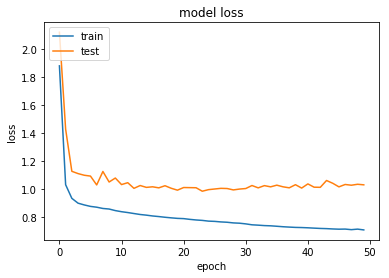

In [97]:
%matplotlib inline
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test error

In [98]:
##############
# Evaluate using keras evaluate()
##############

x_test = [test["userID"], test["itemID"], test["dayofweek"], test["hourofday"], test["monthofyear"]]
evaluate_loss = model.evaluate(x=x_test, y=test["rating"], batch_size=128)
evaluate_loss

25008/25008 [==============================] - 0s 11us/step


0.9968751991550204

In [99]:
##############
# Evaluate using keras predict() and keras metrics
##############

from keras import metrics
import keras

y_test_pred = model.predict(x_test)

mse = metrics.mean_squared_error(test["rating"], y_test_pred.flatten())
tf_session = keras.backend.get_session()
mse.eval(session=tf_session)

0.9968751952079705

In [100]:
##############
# Evaluate using keras predict() and sklearn metrics
##############

from sklearn.metrics import mean_squared_error
mean_squared_error(test["rating"], y_test_pred.flatten())

0.9968751952079861

## 1 Matrix factorization algorithm

NCF is new neural matrix factorization model, which ensembles Generalized Matrix Factorization (GMF) and Multi-Layer Perceptron (MLP) to unify the strengths of linearity of MF and non-linearity of MLP for modelling the user–item latent structures. NCF can be demonstrated as a framework for GMF and MLP, which is illustrated as below:

<img src="https://recodatasets.blob.core.windows.net/images/NCF.svg?sanitize=true">

This figure shows how to utilize latent vectors of items and users, and then how to fuse outputs from GMF Layer (left) and MLP Layer (right). We will introduce this framework and show how to learn the model parameters in following sections.

### 1.1 The GMF model

In ALS, the ratings are modeled as follows:

$$\hat { r } _ { u , i } = q _ { i } ^ { T } p _ { u }$$

GMF introduces neural CF layer as the output layer of standard MF. In this way, MF can be easily generalized
and extended. For example, if we allow the edge weights of this output layer to be learnt from data without the uniform constraint, it will result in a variant of MF that allows varying importance of latent dimensions. And if we use a non-linear function for activation, it will generalize MF to a non-linear setting which might be more expressive than the linear MF model. GMF can be shown as follows:

$$\hat { r } _ { u , i } = a _ { o u t } \left( h ^ { T } \left( q _ { i } \odot p _ { u } \right) \right)$$

where $\odot$ is element-wise product of vectors. Additionally, ${a}_{out}$ and ${h}$ denote the activation function and edge weights of the output layer respectively. MF can be interpreted as a special case of GMF. Intuitively, if we use an identity function for aout and enforce h to be a uniform vector of 1, we can exactly recover the MF model.

### 1.2 The MLP model

NCF adopts two pathways to model users and items: 1) element-wise product of vectors, 2) concatenation of vectors. To learn interactions after concatenating of users and items latent features, the standard MLP model is applied. In this sense, we can endow the model a large level of flexibility and non-linearity to learn the interactions between $p_{u}$ and $q_{i}$. The details of MLP model are:

For the input layer, there is concatention of user and item vectors:

$$z _ { 1 } = \phi _ { 1 } \left( p _ { u } , q _ { i } \right) = \left[ \begin{array} { c } { p _ { u } } \\ { q _ { i } } \end{array} \right]$$

So for the hidden layers and output layer of MLP, the details are:

$$
\phi _ { l } \left( z _ { l } \right) = a _ { o u t } \left( W _ { l } ^ { T } z _ { l } + b _ { l } \right) , ( l = 2,3 , \ldots , L - 1 )
$$

and:

$$
\hat { r } _ { u , i } = \sigma \left( h ^ { T } \phi \left( z _ { L - 1 } \right) \right)
$$

where ${ W }_{ l }$, ${ b }_{ l }$, and ${ a }_{ out }$ denote the weight matrix, bias vector, and activation function for the $l$-th layer’s perceptron, respectively. For activation functions of MLP layers, one can freely choose sigmoid, hyperbolic tangent (tanh), and Rectifier (ReLU), among others. Because of implicit data task, the activation function of the output layer is defined as sigmoid $\sigma(x)=\frac{1}{1+e^{-x}}$ to restrict the predicted score to be in (0,1).


### 1.3 Fusion of GMF and MLP

To provide more flexibility to the fused model, we allow GMF and MLP to learn separate embeddings, and combine the two models by concatenating their last hidden layer. We get $\phi^{GMF}$ from GMF:

$$\phi _ { u , i } ^ { G M F } = p _ { u } ^ { G M F } \odot q _ { i } ^ { G M F }$$

and obtain $\phi^{MLP}$ from MLP:

$$\phi _ { u , i } ^ { M L P } = a _ { o u t } \left( W _ { L } ^ { T } \left( a _ { o u t } \left( \ldots a _ { o u t } \left( W _ { 2 } ^ { T } \left[ \begin{array} { c } { p _ { u } ^ { M L P } } \\ { q _ { i } ^ { M L P } } \end{array} \right] + b _ { 2 } \right) \ldots \right) \right) + b _ { L }\right.$$

Lastly, we fuse output from GMF and MLP:

$$\hat { r } _ { u , i } = \sigma \left( h ^ { T } \left[ \begin{array} { l } { \phi ^ { G M F } } \\ { \phi ^ { M L P } } \end{array} \right] \right)$$

This model combines the linearity of MF and non-linearity of DNNs for modelling user–item latent structures.

### 1.4 Objective Function

We define the likelihood function as:

$$P \left( \mathcal { R } , \mathcal { R } ^ { - } | \mathbf { P } , \mathbf { Q } , \Theta \right) = \prod _ { ( u , i ) \in \mathcal { R } } \hat { r } _ { u , i } \prod _ { ( u , j ) \in \mathcal { R } ^{ - } } \left( 1 - \hat { r } _ { u , j } \right)$$

Where $\mathcal{R}$ denotes the set of observed interactions, and $\mathcal{ R } ^ { - }$ denotes the set of negative instances. $\mathbf{P}$ and $\mathbf{Q}$ denotes the latent factor matrix for users and items, respectively; and $\Theta$ denotes the model parameters. Taking the negative logarithm of the likelihood, we obatain the objective function to minimize for NCF method, which is known as [binary cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy):

$$L = - \sum _ { ( u , i ) \in \mathcal { R } \cup { \mathcal { R } } ^ { - } } r _ { u , i } \log \hat { r } _ { u , i } + \left( 1 - r _ { u , i } \right) \log \left( 1 - \hat { r } _ { u , i } \right)$$

The optimization can be done by performing Stochastic Gradient Descent (SGD), which is described in the [Surprise SVD deep dive notebook](../02_model/surprise_svd_deep_dive.ipynb). Our SGD method is very similar to the SVD algorithm's.

## 2 TensorFlow implementation of NCF

We will use the Movielens dataset, which is composed of integer ratings from 1 to 5.

We convert Movielens into implicit feedback, and evaluate under our *leave-one-out* evaluation protocol.

You can check the details of implementation in `reco_utils/recommender/ncf`


## 3 TensorFlow NCF movie recommender

### 3.1 Load and split data

To evaluate the performance of item recommendation, we adopted the leave-one-out evaluation.

For each user, we held out his/her latest interaction as the test set and utilized the remaining data for training. We use `python_chrono_split` to achieve this. And since it is too time-consuming to rank all items for every user during evaluation, we followed the common strategy that randomly samples 100 items that are not interacted by the user, ranking the test item among the 100 items. Our test samples will be constructed by `NCFDataset`.

In [10]:
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)

df.head()

,userID,itemID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [11]:
train, test = python_chrono_split(df, 0.75)

### 3.2 Functions of NCF Dataset 

Dataset Class for NCF, where important functions are:

`negative_sampling()`, sample negative user & item pair for every positive instances, with parameter `n_neg`.

`train_loader(batch_size, shuffle=True)`, generate training batch with `batch_size`, also we can set whether `shuffle` this training set.

`test_loader()`, generate test batch by every positive test instance, (eg. \[1, 2, 1\] is a positive user & item pair in test set (\[userID, itemID, rating\] for this tuple). This function returns like \[\[1, 2, 1\], \[1, 3, 0\], \[1,6, 0\], ...\], ie. following our *leave-one-out* evaluation protocol.

In [12]:
data = NCFDataset(train=train, test=test, seed=42)

### 3.3 Train NCF based on TensorFlow
The NCF has a lot of parameters. The most important ones are:

`n_factors`, which controls the dimension of the latent space. Usually, the quality of the training set predictions grows with as n_factors gets higher.

`layer_sizes`, sizes of input layer (and hidden layers) of MLP, input type is list.

`n_epochs`, which defines the number of iteration of the SGD procedure.
Note that both parameter also affect the training time.

`model_type`, we can train single `"MLP"`, `"GMF"` or combined model `"NCF"` by changing the type of model.

We will here set `n_factors` to `4`, `layer_sizes` to `[16,8,4]`,  `n_epochs` to `100`, `batch_size` to 256. To train the model, we simply need to call the `fit()` method.

In [13]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
)

In [ ]:
start_time = time.time()

model.fit(data)

train_time = time.time() - start_time

print("Took {} seconds for training.".format(train_time))

Training model: neumf


## 3.4 Prediction and Evaluation

### 3.4.1 Prediction

Now that our model is fitted, we can call `predict` to get some `predictions`. `predict` returns an internal object Prediction which can be easily converted back to a dataframe:

In [16]:
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test.iterrows()]

test_time = time.time() - start_time

predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
predictions.head()

,userID,itemID,prediction
0,1.0,88.0,0.684982
1,1.0,149.0,0.032923
2,1.0,103.0,0.026047
3,1.0,239.0,0.864664
4,1.0,110.0,0.327991


### 3.4.2 Generic Evaluation
We remove rated movies in the top k recommendations
To compute ranking metrics, we need predictions on all user, item pairs. We remove though the items already watched by the user, since we choose not to recommend them again.

In [17]:
start_time = time.time()

users, items, preds = [], [], []
item = list(train.itemID.unique())
for user in train.userID.unique():
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item)
    preds.extend(list(model.predict(user, item, is_list=True)))

all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

test_time = time.time() - start_time
print("Took {} seconds for prediction.".format(test_time))

Took 3.354566812515259 seconds for prediction.


In [18]:

eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.046610
NDCG:	0.191637
Precision@K:	0.171156
Recall@K:	0.096182


### 3.4.3 "Leave-one-out" Evaluation

We implement the functions to repoduce the leave-one-out evaluation protocol mentioned in original NCF paper.

For each item in test data, we randomly samples 100 items that are not interacted by the user, ranking the test item among the 101 items (1 positive item and 100 negative items). The performance of a ranked list is judged by **Hit Ratio (HR)** and **Normalized Discounted Cumulative Gain (NDCG)**. Finally, we average the values of those ranked lists to obtain the overall HR and NDCG on test data.

We truncated the ranked list at 10 for both metrics. As such, the HR intuitively measures whether the test item is present on the top-10 list, and the NDCG accounts for the position of the hit by assigning higher scores to hits at top ranks.

**Note 1:** In exact leave-one-out evaluation protocol, we select only one of the latest items interacted with a user as test data for each user. But in this notebook, to compare with other algorithms, we select latest 25% dataset as test data. So this is an artificial "leave-one-out" evaluation only showing how to use `test_loader` and how to calculate metrics like the original paper. You can reproduce the real leave-one-out evaluation by changing the way of splitting data.

**Note 2:** Because of sampling 100 negative items for each positive test item, 

In [19]:
k = TOP_K

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("HR:\t%f" % eval_hr)
print("NDCG:\t%f" % eval_ndcg)


HR:	0.476767
NDCG:	0.375043


## 3.5 Pre-training

To get better performance of NeuMF, we can adopt pre-training strategy. We first train GMF and MLP with random initializations until convergence. Then use their model parameters as the initialization for the corresponding parts of NeuMF’s parameters.  Please pay attention to the output layer, where we concatenate weights of the two models with

$$h ^ { N C F } \leftarrow \left[ \begin{array} { c } { \alpha h ^ { G M F } } \\ { ( 1 - \alpha ) h ^ { M L P } } \end{array} \right]$$

where $h^{GMF}$ and $h^{MLP}$ denote the $h$ vector of the pretrained GMF and MLP model, respectively; and $\alpha$ is a
hyper-parameter determining the trade-off between the two pre-trained models. We set $\alpha$ = 0.5.

### 3.5.1 Training GMF and MLP model
`model.save`, we can set the `dir_name` to store the parameters of GMF and MLP

In [ ]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="GMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
)

In [20]:
start_time = time.time()

model.fit(data)

train_time = time.time() - start_time

print("Took {} seconds for training.".format(train_time))

model.save(dir_name=".pretrain/GMF")

Training model: gmf
Epoch 10 [6.15s]: train_loss = 0.315140 
Epoch 20 [5.32s]: train_loss = 0.291002 
Epoch 30 [5.03s]: train_loss = 0.272337 
Epoch 40 [5.25s]: train_loss = 0.268146 
Epoch 50 [6.52s]: train_loss = 0.267027 
Epoch 60 [5.32s]: train_loss = 0.267011 
Epoch 70 [6.75s]: train_loss = 0.264637 
Epoch 80 [6.00s]: train_loss = 0.265867 
Epoch 90 [5.73s]: train_loss = 0.264636 
Epoch 100 [4.88s]: train_loss = 0.265541 
Epoch 110 [5.21s]: train_loss = 0.265065 
Epoch 120 [4.91s]: train_loss = 0.264575 
Epoch 130 [4.83s]: train_loss = 0.263862 
Epoch 140 [5.16s]: train_loss = 0.264803 
Epoch 150 [4.94s]: train_loss = 0.264735 
Epoch 160 [5.24s]: train_loss = 0.264377 
Epoch 170 [5.19s]: train_loss = 0.264071 
Epoch 180 [4.92s]: train_loss = 0.263614 
Epoch 190 [4.93s]: train_loss = 0.263399 
Epoch 200 [4.88s]: train_loss = 0.263900 
Took 1042.1958258152008 seconds for training.


In [ ]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="MLP",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
)

start_time = time.time()

In [21]:
model.fit(data)

train_time = time.time() - start_time

print("Took {} seconds for training.".format(train_time))

model.save(dir_name=".pretrain/MLP")

Training model: mlp
Epoch 10 [6.32s]: train_loss = 0.329718 
Epoch 20 [6.08s]: train_loss = 0.296939 
Epoch 30 [6.40s]: train_loss = 0.288913 
Epoch 40 [6.47s]: train_loss = 0.281946 
Epoch 50 [6.08s]: train_loss = 0.278271 
Epoch 60 [6.09s]: train_loss = 0.276184 
Epoch 70 [5.85s]: train_loss = 0.274575 
Epoch 80 [6.17s]: train_loss = 0.272878 
Epoch 90 [6.03s]: train_loss = 0.271775 
Epoch 100 [5.79s]: train_loss = 0.271446 
Epoch 110 [5.87s]: train_loss = 0.270495 
Epoch 120 [5.71s]: train_loss = 0.270673 
Epoch 130 [5.79s]: train_loss = 0.269753 
Epoch 140 [5.70s]: train_loss = 0.269657 
Epoch 150 [5.66s]: train_loss = 0.269295 
Epoch 160 [5.77s]: train_loss = 0.268800 
Epoch 170 [5.63s]: train_loss = 0.267856 
Epoch 180 [5.72s]: train_loss = 0.267994 
Epoch 190 [5.86s]: train_loss = 0.267806 
Epoch 200 [5.57s]: train_loss = 0.267920 
Took 1199.5014789104462 seconds for training.


### 3.5.2 Load pre-trained GMF and MLP model for NeuMF
`model.load`, we can set the `gmf_dir` and `mlp_dir` to store the parameters for NeuMF.

In [ ]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
)

model.load(gmf_dir=".pretrain/GMF", mlp_dir=".pretrain/MLP", alpha=0.5)

In [22]:
start_time = time.time()

model.fit(data)

train_time = time.time() - start_time

print("Took {} seconds for training.".format(train_time))

INFO:tensorflow:Restoring parameters from .pretrain/GMF/model.ckpt
INFO:tensorflow:Restoring parameters from .pretrain/MLP/model.ckpt
Training model: neumf
Epoch 10 [6.52s]: train_loss = 0.229828 
Epoch 20 [6.62s]: train_loss = 0.223956 
Epoch 30 [7.37s]: train_loss = 0.221767 
Epoch 40 [6.70s]: train_loss = 0.219329 
Epoch 50 [6.68s]: train_loss = 0.218969 
Epoch 60 [6.64s]: train_loss = 0.217863 
Epoch 70 [6.63s]: train_loss = 0.217433 
Epoch 80 [6.41s]: train_loss = 0.215627 
Epoch 90 [6.46s]: train_loss = 0.215249 
Epoch 100 [6.47s]: train_loss = 0.215688 
Epoch 110 [6.49s]: train_loss = 0.215189 
Epoch 120 [7.85s]: train_loss = 0.213904 
Epoch 130 [6.69s]: train_loss = 0.213772 
Epoch 140 [8.85s]: train_loss = 0.214469 
Epoch 150 [6.75s]: train_loss = 0.214124 
Epoch 160 [6.84s]: train_loss = 0.213270 
Epoch 170 [7.15s]: train_loss = 0.213109 
Epoch 180 [7.07s]: train_loss = 0.213228 
Epoch 190 [7.09s]: train_loss = 0.212264 
Epoch 200 [6.88s]: train_loss = 0.212478 
Took 1373.573

### 3.5.3 Compare with not pre-trained NeuMF

You can use beforementioned evaluation methods to evaluate the pre-trained `NCF` Model. Usually, we will find the performance of pre-trained NCF is better than the not pre-trained.

In [23]:
start_time = time.time()

users, items, preds = [], [], []
item = list(train.itemID.unique())
for user in train.userID.unique():
    user = [user] * len(item) 
    users.extend(user)
    items.extend(item)
    preds.extend(list(model.predict(user, item, is_list=True)))

all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

test_time = time.time() - start_time
print("Took {} seconds for prediction.".format(test_time))

Took 3.304403066635132 seconds for prediction.


In [24]:
eval_map2 = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg2 = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision2 = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall2 = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map2,
      "NDCG:\t%f" % eval_ndcg2,
      "Precision@K:\t%f" % eval_precision2,
      "Recall@K:\t%f" % eval_recall2, sep='\n')

MAP:	0.049452
NDCG:	0.202544
Precision@K:	0.180594
Recall@K:	0.100380


In [ ]:
# Record results with papermill for tests
pm.record("map", eval_map)
pm.record("ndcg", eval_ndcg)
pm.record("precision", eval_precision)
pm.record("recall", eval_recall)
pm.record("map2", eval_map2)
pm.record("ndcg2", eval_ndcg2)
pm.record("precision2", eval_precision2)
pm.record("recall2", eval_recall2)

### 3.5.4 Delete pre-trained directory

In [2]:
save_dir = ".pretrain"
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    
print("Did \'%s\' exist?: %s" % (save_dir, os.path.exists(save_dir)))

Did '.pretrain' exist?: False


### Reference: 
1. Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu & Tat-Seng Chua Neural Collaborative Filtering: https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf

2. Official NCF implementation [Keras with Theano]: https://github.com/hexiangnan/neural_collaborative_filtering

3. Other nice NCF implementation [Pytorch]: https://github.com/LaceyChen17/neural-collaborative-filtering